
# Two-Node LangGraph RAG System (Retrieve → Generate)

**Objective:** Build a standard Retrieval-Augmented Generation (RAG) system using **LangGraph** with two nodes:
1. **Retrieval Node**: Uses a hybrid retriever to fetch relevant chunks and stores them in `retrieved_docs` in the state.
2. **Generation Node**: Formats retrieved docs, runs a RAG prompt with an LLM, and stores the final string answer in `answer`.

**Architecture:** `question → retrieve_node → generate_node → answer`

![](https://i.imgur.com/FtKPvC8.png)

This notebook demonstrates how to use a Retrieval-Augmented Generation (RAG) system to assist operations, audit, and transformation teams in querying past findings and recommendations. The goal is to enable fast, accurate answers based on internal process narratives, helping organizations:

- Understand root causes of workflow inefficiencies
- Recommend remediation strategies
- Identify patterns across departments
- Track outcomes of automation interventions (e.g., AutoFlow Insight)


## Environment & Dependencies
Install libraries and set the API key.

In [1]:
!pip install langgraph==0.6.5 langchain==0.3.27 langchain-openai==0.3.29 langchain-community==0.3.27 langchain-chroma==0.2.5 rank-bm25==0.2.2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.8/450.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.6/948.6 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.9 MB/s eta 0:00

## Enter API Keys & Setup Environment Variables

In [2]:
import os
import getpass

# OpenAI API Key (for chat & embeddings)
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key (https://platform.openai.com/account/api-keys):\n")

Enter your OpenAI API key (https://platform.openai.com/account/api-keys):
··········



## Data Loading & Preprocessing

We will:
- Download the JSONL dataset from Google Drive
- Load JSON lines into Python
- Build `Document` objects



In [3]:
!gdown 1u8ImzhGW2wgIib16Z_wYIaka7sYI_TGK

Downloading...
From: https://drive.google.com/uc?id=1u8ImzhGW2wgIib16Z_wYIaka7sYI_TGK
To: /content/rag_demo_docs052025.jsonl
100% 72.8k/72.8k [00:00<00:00, 50.6MB/s]


In [4]:
from pathlib import Path
import json
from langchain.docstore.document import Document

# ---- Configure dataset path (update if needed) ----
DATA_PATH = Path("./rag_demo_docs052025.jsonl")  # same file name as earlier notebook

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Expected dataset at {DATA_PATH}. "
        "Please place the JSONL file here or update DATA_PATH."
    )

# Load JSONL
raw_docs = []
with DATA_PATH.open("r", encoding="utf-8") as f:
    for line in f:
        raw_docs.append(json.loads(line))

# Convert to Document objects with metadata
documents = []
for i, d in enumerate(raw_docs):
    sect = d.get("sectioned_report", {})
    text = (
        f"Issue:\n{sect.get('Issue','')}\n\n"
        f"Impact:\n{sect.get('Impact','')}\n\n"
        f"Root Cause:\n{sect.get('Root Cause','')}\n\n"
        f"Recommendation:\n{sect.get('Recommendation','')}"
    )

    documents.append(Document(page_content=text))

In [5]:
print(documents[0].page_content)

Issue:
During Q1, the claims approval workflow suffered from persistent operational delays. Teams across the board cited slow decision cycles and manual exception handling as primary contributors to SLA violations. This was especially apparent within procurement, where approvals frequently stalled due to the absence of a defined fallback or escalation path.

Impact:
As a result, overall cycle time efficiency declined by more than 40% compared to the previous quarter. Department 3 experienced a notable increase in vendor complaints and late invoice settlements. Internal performance KPIs dropped, and multiple high-priority requests breached their service windows, raising concern at the executive level.

Root Cause:
The root cause analysis revealed systemic gaps in workflow configuration. Key issues included missing backup approvers, inconsistent exception triage routing, and lack of automated validation for essential metadata. Inboxes used for routing escalations were unmonitored, causin


## Embeddings & Vector Store (Chroma)

- OpenAI `text-embedding-3-small`
- Chroma with cosine space
- Persist to disk so you can reuse


In [6]:
!rm -rf reports_db

In [7]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

persist_dir = "./reports_db"
collection = "reports_db"

embedder = OpenAIEmbeddings(model="text-embedding-3-small")

# Build or rebuild the vector store
vectordb = Chroma.from_documents(
    documents=documents,
    embedding=embedder,
    collection_name=collection,
    collection_metadata={"hnsw:space": "cosine"},
    persist_directory=persist_dir
)


## Retrievers (Hybrid Search)

We use the following retrieval strategy:
- Semantic similarity (with a score threshold)
- BM25 keyword retriever
- Ensemble hybrid combination



In [8]:
# Reopen handle (demonstrates persistence)
vectordb = Chroma(
    embedding_function=embedder,
    collection_name=collection,
    persist_directory=persist_dir,
)
vectordb._collection.count()

30

In [9]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.retrievers import ContextualCompressionRetriever

# Base semantic retriever (cosine sim + threshold)
semantic = vectordb.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 5, "score_threshold": 0.2},
)

# BM25 keyword retriever
bm25 = BM25Retriever.from_documents(documents)
bm25.k = 3

# Ensemble (hybrid)
hybrid_retriever = EnsembleRetriever(
    retrievers=[bm25, semantic],
    weights=[0.6, 0.4],
    k=5
)

In [10]:
# Quick test
hybrid_retriever.invoke("What are the major issues in finance approval workflows?")[:3]

[Document(metadata={}, page_content='Issue:\nHigh-priority tasks in the finance automation pipeline were repeatedly delayed due to outdated approval logic. Workflows didn’t adapt to user absences, resulting in pending items aging beyond acceptable SLA limits.\n\nImpact:\nDepartment 1 saw over 60 delayed approvals in Q1, affecting scheduled disbursements and financial close accuracy. Several compliance reviews noted the same failure pattern recurring across different finance units.\n\nRoot Cause:\nApprover calendars were not integrated with workflow routing. Fallback reviewers were missing in 40% of workflows, and escalation triggers did not factor in holiday or leave schedules.\n\nRecommendation:\nAutomated calendar checks must be enforced during approval assignment. Fallback logic should auto-activate when a primary approver is unavailable. AutoFlow Insight now runs pre-approval checks in Department 1 to ensure routing logic reflects real-time availability.'),
 Document(metadata={}, p


## LangGraph State Definition

We define a simple **state schema** with overwrite behavior (single-turn flow):

- `question: str`
- `retrieved_docs: list[Document]`
- `answer: str`


In [11]:

from typing import List, TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langchain.docstore.document import Document as LCDocument

# We keep overwrite semantics for all keys (no reducers needed for appends here).
class RAGState(TypedDict):
    question: str
    retrieved_docs: List[LCDocument]
    answer: str



## Node 1 — Retrieval Node

- Reads `state['question']`
- Calls `retriever.invoke(question)` (as used in your notebook)
- Writes documents into `state['retrieved_docs']`


In [12]:

def retrieve_node(state: RAGState) -> RAGState:
    query = state["question"]
    docs = hybrid_retriever.invoke(query)  # returns list[Document]
    return {"retrieved_docs": docs}



## Node 2 — Generation Node (RAG prompt)

- Formats retrieved docs into a context string
- Uses a grounded prompt: answer only from context, otherwise say you don't know
- Stores result text in `state['answer']`


In [13]:

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

PROMPT = ChatPromptTemplate.from_template(
    """You are an assistant for Analyzing internal reports for Operational Insights.
       Use the following pieces of retrieved context to answer the question.
       If you don't know the answer or there is no relevant context, just say that you don't know.
       give a well-structured and to the point answer using the context information.

       Question:
       {question}

       Context:
       {context}
    """
)

def _format_docs(docs: List[LCDocument]) -> str:
    return "\n\n".join(d.page_content for d in docs) if docs else ""

def generate_node(state: RAGState) -> RAGState:
    question = state["question"]
    docs = state.get("retrieved_docs", [])
    context = _format_docs(docs)
    prompt = PROMPT.format(question=question, context=context)
    resp = llm.invoke(prompt)
    return {"answer": resp.content}



## Build the Graph & Edges

`START → retrieve_node → generate_node → END`


In [14]:
builder = StateGraph(RAGState)

builder.add_node("retrieve", retrieve_node)
builder.add_node("generate", generate_node)

builder.add_edge(START, "retrieve")
builder.add_edge("retrieve", "generate")
builder.add_edge("generate", END)

graph = builder.compile()

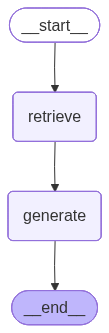

In [15]:
from IPython.display import Image, display, display_markdown

display(Image(graph.get_graph().draw_mermaid_png()))


## Run Examples

Invoke with a question and read back the final `answer` from the state.


In [16]:
example_q = "What are the major issues in finance approval workflows?"
final_state = graph.invoke({"question": example_q})
final_state

{'question': 'What are the major issues in finance approval workflows?',
 'retrieved_docs': [Document(metadata={}, page_content='Issue:\nHigh-priority tasks in the finance automation pipeline were repeatedly delayed due to outdated approval logic. Workflows didn’t adapt to user absences, resulting in pending items aging beyond acceptable SLA limits.\n\nImpact:\nDepartment 1 saw over 60 delayed approvals in Q1, affecting scheduled disbursements and financial close accuracy. Several compliance reviews noted the same failure pattern recurring across different finance units.\n\nRoot Cause:\nApprover calendars were not integrated with workflow routing. Fallback reviewers were missing in 40% of workflows, and escalation triggers did not factor in holiday or leave schedules.\n\nRecommendation:\nAutomated calendar checks must be enforced during approval assignment. Fallback logic should auto-activate when a primary approver is unavailable. AutoFlow Insight now runs pre-approval checks in Depar

In [17]:
display_markdown(final_state["answer"], raw=True)

The major issues in finance approval workflows include:

1. **Outdated Approval Logic**: High-priority tasks are delayed due to workflows that do not adapt to user absences, leading to aging pending items beyond acceptable SLA limits.

2. **Lack of Fallback and Escalation Paths**: Many workflows lack fallback reviewers (missing in 40% of cases) and do not have escalation triggers that consider holidays or leave schedules, causing delays when primary approvers are unavailable.

3. **Manual Handling of Exceptions**: There is a reliance on manual exception handling, which leads to inefficiencies and increased processing times. Invoices often get stuck in pending status due to the absence of automated routing for exceptions.

4. **Static Approval Chains**: Approval processes are often static, with no dynamic reassignment logic, resulting in urgent invoices stagnating when routed to out-of-office managers.

5. **Inadequate Automation Coverage**: Insufficient automation in key validation and routing steps leads to unresolved exceptions and increased operational risks, as seen in multiple departments.

6. **Poor Integration of Approver Calendars**: Approver availability is not synchronized with workflow systems, leading to delays in approvals and missed deadlines.

These issues collectively contribute to increased processing times, vendor dissatisfaction, and operational risks across various finance departments. Recommendations include implementing automated calendar checks, dynamic routing logic, and structured fallback policies to enhance workflow efficiency and compliance.

In [18]:
example_q = "What caused invoice SLA breaches in the last quarter?"
final_state = graph.invoke({"question": example_q})
display_markdown(final_state["answer"], raw=True)

The invoice SLA breaches in the last quarter were primarily caused by persistent inefficiencies in the invoice processing workflow, particularly within finance operations. Key contributing factors included:

1. **Manual Handling of Edge Cases**: Invoices often required manual intervention for exceptions, leading to delays.
2. **Delays in Managerial Approvals**: Invoices were frequently stuck in pending status due to the unavailability of primary approvers, with no fallback or escalation paths established.
3. **Lack of Automation**: There was a failure to automate key validation and routing steps, resulting in unresolved exceptions and stagnant invoices.
4. **Inconsistent Assignment of Fallback Approvers**: This created blind spots in the approval process, allowing SLA-sensitive invoices to remain unaddressed.
5. **Poor Triage Logic**: Inconsistent triage speed for exceptions led to some invoices being reviewed quickly while others languished without intervention.

These issues culminated in a significant increase in average invoice cycle time, vendor complaints, and operational risks, ultimately leading to multiple SLA breaches.

In [19]:
example_q = "How did AutoFlow Insight improve SLA adherence?"
final_state = graph.invoke({"question": example_q})
display_markdown(final_state["answer"], raw=True)

AutoFlow Insight improved SLA adherence by implementing several key enhancements across various departments. These improvements included:

1. **Automated Reassignment and Fallback Logic**: AutoFlow Insight introduced auto-delegation and fallback configurations for high-risk workflows, ensuring that approval responsibilities were reassigned during planned absences. This addressed the issue of delays caused by inactive approvers and improved routing visibility.

2. **Real-Time Monitoring and Alerts**: The integration of dashboards with real-time alerting for missed deadlines allowed teams to monitor exception queues effectively. This proactive approach helped in identifying and addressing bottlenecks before they escalated into larger issues.

3. **Calendar Integration**: By running pre-approval checks that integrated approver calendars, AutoFlow Insight ensured that workflows adapted to user absences. This prevented pending items from aging beyond acceptable SLA limits.

4. **Enhanced Workflow Intelligence**: The system provided milestone tracking for approval nodes and enforced calendar-aware routing, which improved the overall efficiency of contract and invoice processing workflows.

5. **Metadata Enrichment**: AutoFlow Insight enriched ticket metadata, which reduced rework and improved routing decisions, thereby enhancing the speed and accuracy of ticket resolutions.

Overall, these enhancements led to measurable improvements in SLA compliance, with departments reporting significant reductions in turnaround times and increased operational efficiency. For instance, Department 4 noted a drop in invoice turnaround time and improved compliance with SLA targets after implementing AutoFlow Insight.